### This notebook will demonstrate 3 results.
1. Rotate the 2D slice image with Bessel function, stack the images back into a volume and compute the cost functions.
2. Translate the volume with a wrap around behavior to preserve energy inside of the volume, and compute cost functions with and without Halton sampling.
3. Maximum Likelihood Estimates of transformed images.

### Set up

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
from scipy import ndimage
import ghalton
from scipy.interpolate import interp1d

In [94]:
'''
Helper function that cleans up list_directory
removes hidden files
'''
def clean(lis):
    try:
         
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

'''
Helper function that retrieves all data files
cleans up the directory to leave only .dat files
'''
def get_files(lis):
    try:
        for i in list(lis):
            if('.dat' not in i):
                lis.remove(i)
    except:
        lis = lis
    return lis

###Function Definitions

In [95]:
# Bessel Rotation
def to_radian(theta):
    return theta*np.pi/180.

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image

def bessel_rotate(image, theta, mask = False):
    t0 = time.time()
    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
                Bess[mask_R] = 0.5
                Ib[i+s,j+s] = (np.sum(image*Bess))*np.pi/2
    if(mask):
        Ib = circle_mask(Ib)
    t1 = time.time()
    return Ib

In [96]:
def sphere_mask(volume):
    
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    r = len(volume)/2.-0.5
    
    x,y,z = np.ogrid[-ox:volume.shape[1]-ox, -oy:volume.shape[0]-oy,-oz:volume.shape[2]-oz]
    mask = (x*x + y*y + z*z <= r*r)
    vol = np.array(volume)
    vol[~mask] = 0
    return vol

def rotation_matrix_zyx(gamma, beta, alpha):
    """
    Return the rotation matrix associated with counterclockwise rotation 
    about x axis by gamma degrees
    about y axis by beta degrees
    about z axis by alpha degrees
    """
    # convert degrees to radians
    gamma = to_radian(gamma)
    beta = to_radian(beta)
    alpha = to_radian(alpha)
    
    rz = np.array([[np.cos(alpha),-np.sin(alpha),0],[np.sin(alpha),np.cos(alpha),0],[0,0,1]])
    ry = np.array([[np.cos(beta),0, np.sin(beta)],[0, 1, 0],[-np.sin(beta),0,np.cos(beta)]])
    rx = np.array([[1,0,0],[0,np.cos(gamma),-np.sin(gamma)],[0,np.sin(gamma),np.cos(gamma)]])
    return (rz.dot(ry)).dot(rx)

# Bessel Rotation in 3D
def bessel_rotate_3d(volume, gamma, beta, alpha, mask = False):
    t0 = time.time()
    Ib = np.zeros(volume.shape)
    
    s = (volume.shape[0]-1)/2.

    x = np.linspace(-s, s, volume.shape[1])
    y = np.linspace(-s, s, volume.shape[0])
    z = np.linspace(-s, s, volume.shape[2])
    
    xx, yy, zz = np.meshgrid(x,y,z)
    
    rM = rotation_matrix_zyx(gamma, beta, alpha)

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            for k in np.arange(-s,s+1):
                x = np.dot(rM, np.array([i,j,k]))
                
                if(np.sum(abs(x)>s)):
                    Ib[i+s,j+s,k+s] = 0

                else:
                    R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2 + (zz-x[2])**2)
                    mask_R = (R == 0)
                    Bess = np.zeros(R.shape)
                    Bess[~mask_R] = ((np.sin(np.pi*R[~mask_R])/(np.pi*R[~mask_R])) - np.cos(np.pi*R[~mask_R]))/(2*np.pi*R[~mask_R]**2)
                    Bess[mask_R] = 0.5
                    Ib[i+s,j+s,k+s] = (np.sum(volume*Bess))*np.pi/2
    if(mask):
        Ib = sphere_mask(volume)
    t1 = time.time()
    #print 'time for bessel rotate 3D %.3f seconds' % (t1-t0)
    return Ib

In [97]:
# Trilinear Interpolation
def trilinear_interp(volume, x, y, z):
    # find the closest grid of the target points
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    z0 = np.floor(z).astype(int)
    z1 = z0 + 1

    # Clip
    x0 = x0.clip(0, volume.shape[0]-1)
    x1 = x1.clip(0, volume.shape[0]-1)
    y0 = y0.clip(0, volume.shape[1]-1)
    y1 = y1.clip(0, volume.shape[1]-1)
    z0 = z0.clip(0, volume.shape[2]-1)
    z1 = z1.clip(0, volume.shape[2]-1) 
    
    # define some coefficients
    xd = x-x0
    yd = y-y0
    zd = z-z0
    
    # set up for the bilinear interpolation

    C00 = volume[y0,x0,z0]*(1-xd) + volume[y0,x1,z0]*xd
    C10 = volume[y1,x0,z0]*(1-xd) + volume[y1,x1,z0]*xd
    
    C01 = volume[y0,x0,z1]*(1-xd) + volume[y0,x1,z1]*xd
    C11 = volume[y1,x0,z1]*(1-xd) + volume[y1,x1,z1]*xd
    
    C0 = C00*(1-yd) + C10*yd
    C1 = C01*(1-yd) + C11*yd
    
    C = C0*(1-zd) + C1*zd
    return C

**Cost Functions**

In [98]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

In [99]:
def rot_cost_func(vol1, vol2, thetas, cf, arg, ax, interpolation = 'bilinear', mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    tmp = vol1.copy()
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(32):
            sub = vol2[i,:,:]
            if(interpolation == 'bessel'):
                rot = bessel_rotate(sub, t, mask)
            else:
                rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
        cost_func[idx] = cf(new_vol2,tmp)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)
    
def rot_cost_func_3d(vol1, vol2, thetas, cf, arg, ax, interpolation = 'bilinear', mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        if(interpolation == 'bessel'):
            new_vol2 = bessel_rotate_3d(vol2, 0,t,0, mask)
        else:
            new_vol2 = volrotate_quaternion(sub, th,0,1,0,mask=mask)
        cost_func[idx] = cf(new_vol2,vol1)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)

In [186]:
def translation1(volume, t):
    return scipy.ndimage.interpolation.shift(volume, t, order=1, mode='wrap')

# Trilinear Interpolation
def translation(volume, x, y, z):
    
    # find the closest grid of the target points
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    z0 = np.floor(z).astype(int)
    z1 = z0 + 1

    # Clip
    x0 = (x0 + volume.shape[1]) % volume.shape[1]
    x1 = (x1 + volume.shape[1]) % volume.shape[1]
    y0 = (y0 + volume.shape[0]) % volume.shape[0]
    y1 = (y1 + volume.shape[0]) % volume.shape[0]
    z0 = (z0 + volume.shape[2]) % volume.shape[2]
    z1 = (z1 + volume.shape[2]) % volume.shape[2] 
    
    x = (x + volume.shape[1]) % volume.shape[1]
    y = (y + volume.shape[0]) % volume.shape[0]
    z = (z + volume.shape[2]) % volume.shape[2]
    # define some coefficients
    xd = x-x0
    yd = y-y0
    zd = z-z0
    
    # set up for the bilinear interpolation

    C00 = volume[y0,x0,z0]*(1-xd) + volume[y0,x1,z0]*xd
    C10 = volume[y1,x0,z0]*(1-xd) + volume[y1,x1,z0]*xd
    
    C01 = volume[y0,x0,z1]*(1-xd) + volume[y0,x1,z1]*xd
    C11 = volume[y1,x0,z1]*(1-xd) + volume[y1,x1,z1]*xd
    
    C0 = C00*(1-yd) + C10*yd
    C1 = C01*(1-yd) + C11*yd
    
    C = C0*(1-zd) + C1*zd
    return C

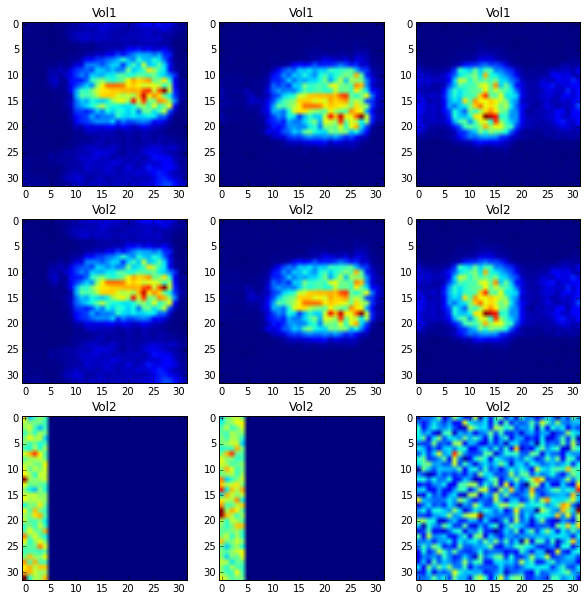

In [193]:
x = np.linspace(0, vol1.shape[1]-1, vol1.shape[1]).astype(int)
y = np.linspace(0, vol1.shape[0]-1, vol1.shape[0]).astype(int)
z = np.linspace(0, vol1.shape[2]-1, vol1.shape[2]).astype(int)
xx, yy, zz = np.meshgrid(x, y, z)
v3_trans1 = translation1(vol3,[0,0,5])
v3_trans = translation(vol3,xx,yy,zz-5)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(10)
[ax[0][i].imshow(v3_trans1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Vol1') for i in xrange(3)]
[ax[1][i].imshow(v3_trans.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Vol2') for i in xrange(3)]
[ax[2][i].imshow(abs(v3_trans-v3_trans1).max(axis=i)) for i in xrange(3)]
[ax[2][i].set_title('Vol2') for i in xrange(3)]
plt.show()
plt.close(fig)

In [198]:
def vol_cost_func_t(vol1, vol2, t, cf, arg, ax):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    t: list of translation to try
    cf: cost function
    arg: string for plot titles
    '''
    x = np.linspace(0, vol1.shape[1]-1, vol1.shape[1]).astype(int)
    y = np.linspace(0, vol1.shape[0]-1, vol1.shape[0]).astype(int)
    z = np.linspace(0, vol1.shape[2]-1, vol1.shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(x, y, z)
    
    cost_func = np.zeros(len(t))
    for idx, th in enumerate(t):
        #new_vol2 = translation(vol2, xx+th[1], yy+th[0], zz+th[2])
        new_vol2 = translation1(vol2,th)
        cost_func[idx] = cf(new_vol2,vol1)
    tMin = t[np.argmin(cost_func)]
    t = np.array(t)
    ax.plot((t*8.)[:,2],cost_func,label='Min translation = %s' % (tMin[2]*8.))
    ax.set_title('%s Cost function with trilinear interpolation' % (arg), fontsize=14)
    ax.set_xlabel('Translation (mm)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=1)

In [182]:
def halton_cost_func_t(N, vol1, vol2, t, arg, mask=False):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    theta: rotation by degrees
    t: list of translations to try
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(t))
    t0 = time.time()
    # generate Halton Sequence in the 32*32*32 grid
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    z1 = 31 * pts[:,2]
    x1, y1, z1 = np.meshgrid(x1, y1, z1)
    for idx, th in enumerate(t):
        v2 = trilinear_interp(vol2, x1+th[0], y1+th[1], z1+th[2])
        v1 = trilinear_interp(vol1, x1, y1, z1)
        #new_vol2 = translation(v2, th)
        cost_func[idx] = cf_ssd(v2,v1)
    t1 = time.time()
    print 'Time for %s halton samples is %s seconds' % (N,t1-t0) 

    tMin = t[np.argmin(cost_func)]
    t = np.array(t)
    plt.plot((t*8.)[:,2],cost_func,label='Min translation = %s' % (tMin[2]*8.))
    plt.title('%s Cost function with trilinear interpolation' % (arg), fontsize=14)
    plt.xlabel('Translation (mm)')
    plt.ylabel('Cost function')
    plt.legend(loc=1)
    plt.show()

In [12]:
def to_radian(theta):
    '''
    Convert theta from degrees to radians
    '''
    return theta*np.pi/180.


def Hamilton_product(a1, b1, c1, d1, a2, b2, c2, d2):
    a = a1*a2-b1*b2-c1*c2-d1*d2
    i = a1*b2+b1*a2+c1*d2-d1*c2
    j = a1*c2-b1*d2+c1*a2+d1*b2
    k = a1*d2+b1*c2-c1*b2+d1*a2
    return a, i, j, k

def rotate_coords_quaternion(theta, ui, uj, uk, t, x, y, z):
    """
    Return the position of rotated point about quaternion u by theta degrees
    """
    ox = oy = oz = 15.5
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    
    # convert degrees to radians
    theta = to_radian(theta)
    qr = np.cos(theta/2.)
    s = np.sin(theta/2.)
    
    # coefficients for q and q^-1
    a1 = qr
    b1 = ui*s
    c1 = uj*s
    d1 = uk*s

    # calculate q*p*q^-1
    qp_a1, qp_b1, qp_c1, qp_d1 = Hamilton_product(a1,b1,c1,d1,0,x,y,z)
    
    # calculate final coordinates
    a, b, c, d = Hamilton_product(qp_a1, qp_b1, qp_c1, qp_d1,a1,-b1,-c1,-d1)
    
    return b + t[0] + ox, c + t[1] + oy, d + t[1] + oz

def volrotate_quaternion(volume, theta, ui, uj, uk, t = np.array([0,0,0]), mask=False):
    """
    Rotate a given volume by theta degrees about the unit quarternion u
    """
    # find center of the volume
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    x = np.linspace(0, volume.shape[1]-1, volume.shape[1]).astype(int)
    y = np.linspace(0, volume.shape[0]-1, volume.shape[0]).astype(int)
    z = np.linspace(0, volume.shape[2]-1, volume.shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(x, y, z)
    
    dest_x, dest_y, dest_z = rotate_coords_quaternion(theta, ui, uj, uk, t, xx, yy, zz)
    
    dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    
    if(mask):
        dest = sphere_mask(dest)
    return dest

In [13]:
def Maximum_Likelihood(vol1, vol2, thetas, t, cf, arg, ax, interpolation='trilinear',rotate = None, mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    prob = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        if(rotate == 'q'):
            new_vol2 = volrotate_quaternion(vol2, th, 0, 1, 0, t)
        else:
            new_vol2 = volrotate(vol2, 0, th, 0, t, interpolation)
        prob[idx] = np.sum(scipy.stats.norm.logpdf((new_vol2-vol1).ravel(),loc = 0,scale=0.5))
    pMin = thetas[np.argmax(prob)]
    ax.plot(thetas, prob, label='Max prob occurs at = %s' % (pMin))
    ax.set_title('%s Maximum Likelihood with trilinear interpolation\n' % (arg), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Log Likelihood')
    ax.legend(fontsize=12)

# 1. Bessel Rotation

Read in Test Data Set 1: One Pineapple with 5 degrees rotation. Select two volumes for testing and visulize them.

In [16]:
path = '/Users/zyzdiana/Dropbox/Spring2015/AC297r/Pineapple_images/'
files = get_files(os.listdir(path))

# Choose two volume and slice them to for testing.
vol1 = np.array(np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32)))
vol2 = np.array(np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32)))

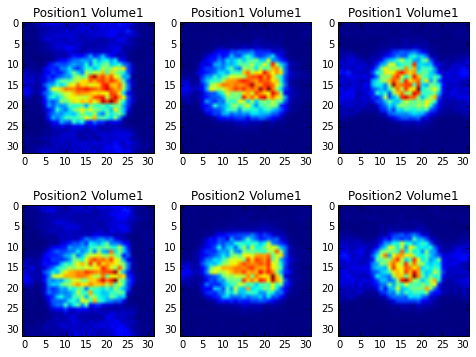

In [14]:
# Visulize the selected volumes
fig, ax = plt.subplots(2,3)
fig.set_figwidth(8)
fig.set_figheight(6)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 Volume%s' % (1)) for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position2 Volume%s' % (1)) for i in xrange(3)]
plt.show()
plt.close(fig)

With the Bessel function, the discontinuity at zero in the SSD cost function was removed, and the curve is nice and smooth within the range [-5,10] degrees.

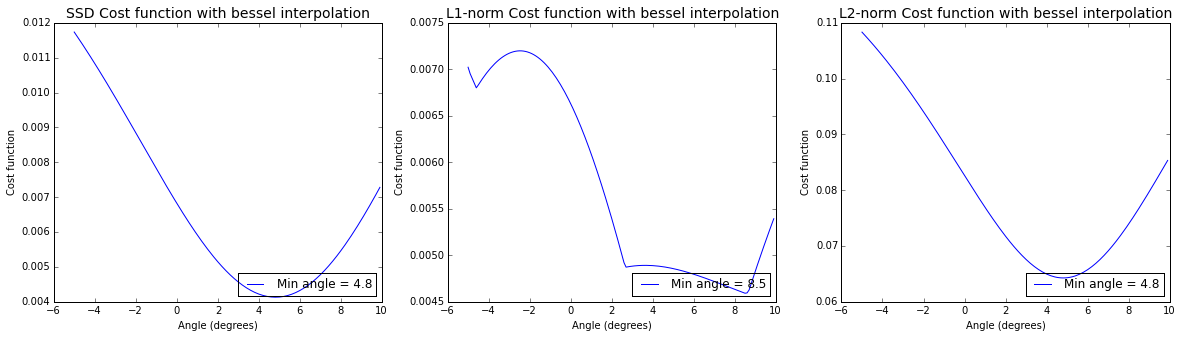

In [26]:
# Cost function from Bessel Rotation
thetas=np.arange(-5,10,0.1)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

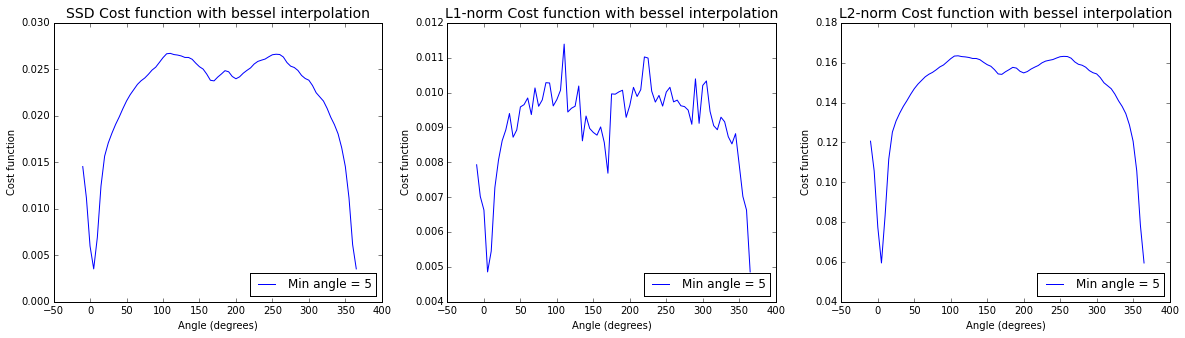

In [99]:
# Cost function from Bessel Rotation on a wider range
thetas=np.arange(-10,370,5)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bessel')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bessel')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bessel')
plt.show()
plt.close(fig)

In [ ]:
# Cost function from Bessel Rotation in 3D
thetas=np.arange(-6,-4,0.5)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func_3d(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func_3d(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func_3d(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

# 1. Translation Cost Function with Halton Sampling
Read in Test Data Set 2: One Pineapple with 10mm translation. Select two volumes for testing and visulize them.

In [105]:
path1 = '/Users/zyzdiana/Dropbox/vNav_Test_Data/'
files1 = get_files(os.listdir(path1))
pos1 = files1[:(len(files1)/2)]
pos2 = files1[(len(files1)/2):]

vol2 = np.memmap(path1+pos1[5], dtype=np.float32, shape=(32,32,32))
vol2 = np.array(vol2)
vol3 = np.memmap(path1+pos1[10], dtype=np.float32, shape=(32,32,32))
vol3 = np.array(vol3)

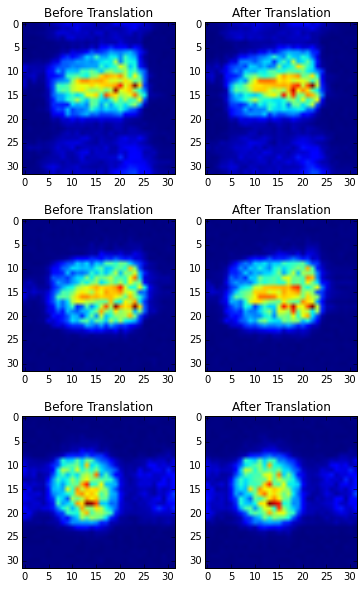

In [60]:
fig, ax = plt.subplots(3,2)
fig.set_figwidth(6)
fig.set_figheight(10)
[ax[i][0].imshow(vol2.max(axis=i),cmap='jet') for i in xrange(3)]
[ax[i][0].set_title('Before Translation') for i in xrange(3)]
[ax[i][1].imshow(vol3.max(axis=i),cmap='jet') for i in xrange(3)]
[ax[i][1].set_title('After Translation') for i in xrange(3)]
plt.show()
plt.close(fig)

###Discrete SSD

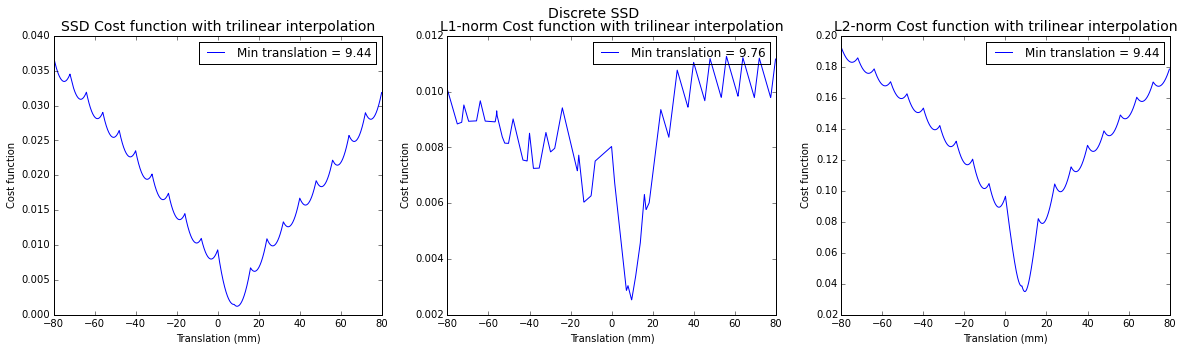

In [200]:
# Translation
t = []
for i in np.arange(-10,10,0.01):
    t.append([0,0,i])   
# Discrete Sum Cost Function
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Discrete SSD", fontsize=14)
vol_cost_func_t(vol2, vol3, t, cf_ssd, 'SSD',ax[0])
vol_cost_func_t(vol2, vol3, t, cf_L1, 'L1-norm',ax[1])
vol_cost_func_t(vol2, vol3, t, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

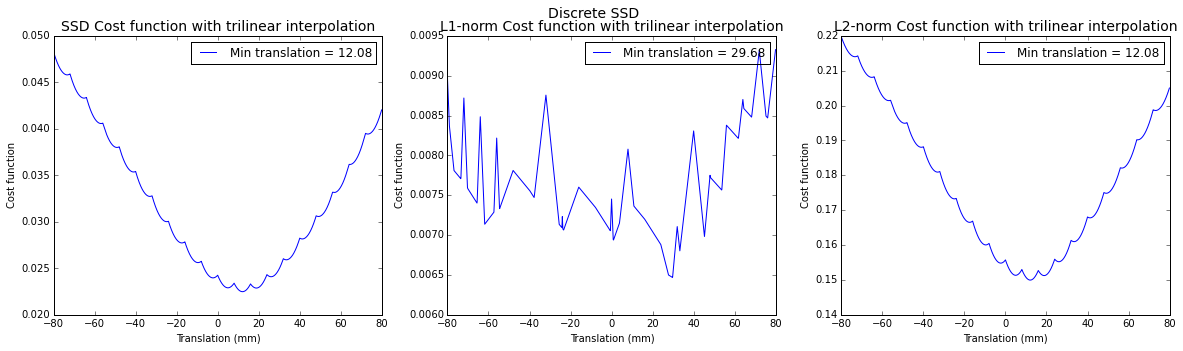

In [201]:
# rotate volume 3 first, and then translation, and compare with vol1
new_vol3 = volrotate_quaternion(vol3,-5,0,1,0)
# Translation
t = []
for i in np.arange(-10,10,0.01):
    t.append([0,0,i])   
# Discrete Sum Cost Function
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Discrete SSD", fontsize=14)
vol_cost_func_t(vol1, new_vol3, t, cf_ssd, 'SSD',ax[0])
vol_cost_func_t(vol1, new_vol3, t, cf_L1, 'L1-norm',ax[1])
vol_cost_func_t(vol1, new_vol3, t, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

###Integral SSD with Halton Sampling

In [129]:
# Translation
t = []
for i in np.arange(-5,5,0.1):
    t.append([0,0,i])

Time for 64 halton samples is 72.7974948883 seconds


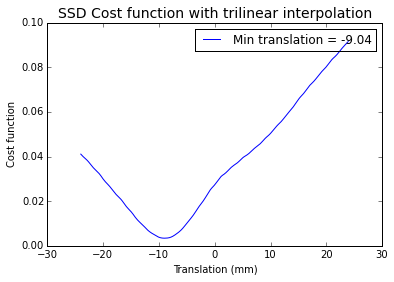

In [183]:
# Integral Cost function with Halton Sampling
halton_cost_func_t(64, vol2, vol3, t, 'SSD')

Time for 64 halton samples is 11.8260111809 seconds


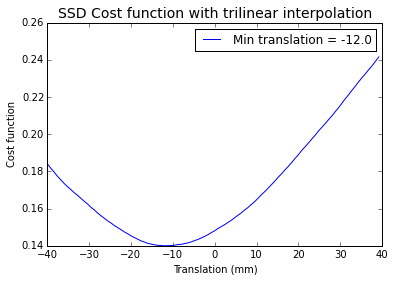

In [203]:
halton_cost_func_t(64,vol1,new_vol3,t,'SSD')

Time for 100 halton samples is 292.091320038 seconds


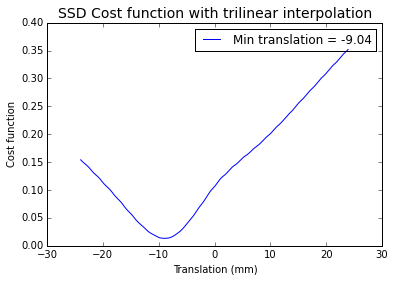

In [184]:
halton_cost_func_t(100, vol2, vol3, t, 'SSD')

Using Halton Sampling to evaluate the SSD cost function did smooth out the cost functiona as well as increasing the precision of the estimate.

# 3. Maximum Likelihood Estimates

Instead of using cost function, I tried using maximum likelihood methods to estimate the rotation. I'm still working on a rigorous proof of the model, but as of right  now, I will demonstrate the result from the data.(Here we are using the two volumes from part 1 with 5 degrees rotation.)

Let's denote the image without movement as `im1` and the image after movement as `im2`. If the `im2` has been rotated back to the original position perfectly, then $$im2 = im1 + \lambda\epsilon$$, where $\epsilon$ is the noise of the image, and $\lambda$ is a scaling constant which we know is normally distributed. We will now compute the difference $\frac{im2-im1}{\lambda}$ and assume it also follows a normal distribution and then do maximum likelihood estimation on the difference.

In [18]:
vol1 = np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32))
vol1 = np.array(vol1)
vol2 = np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32))
vol2 = np.array(vol2)

Below is a distribution plot of the difference between `im1` and rotated `im2`. We can see that they all have according to a $N(0,0.5^2)$ distribution

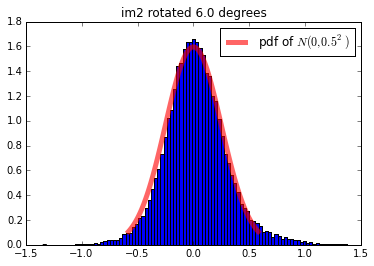

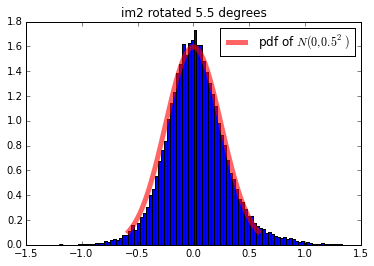

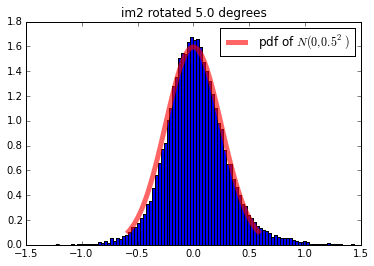

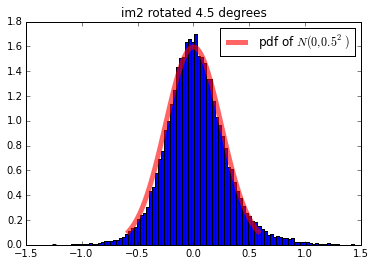

In [19]:
from scipy.stats import norm
thetas=np.arange(-6,-4,0.5)
t = np.zeros([3,])
sig = 0.25
x = np.linspace(norm.ppf(0.01, 0, sig), norm.ppf(0.99, 0, sig), 100)
y = norm.pdf(x, 0, sig)
for th in thetas:
    new_vol2 = volrotate_quaternion(vol2, th, 0, 1, 0, t)
    data = (new_vol2-vol1).ravel()
    plt.hist(2*data/((new_vol2+vol1).ravel()), bins=100, normed=True)
    plt.plot(x, y,'r-', lw=5, alpha=0.6, label = 'pdf of $N(0,0.5^2)$')
    plt.title('im2 rotated %s degrees' % -th)
    plt.legend()
    plt.show()

In [91]:
def Maximum_Likelihood(vol1, vol2, thetas, t, ax, interpolation='trilinear',rotate = None, mask=True):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    prob = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        if(rotate == 'q'):
            new_vol2 = volrotate_quaternion(vol2, th, 0, 1, 0, t)
        else:
            new_vol2 = volrotate(vol2, 0, th, 0, t, interpolation)
        prob[idx] = np.sum(scipy.stats.norm.logpdf((new_vol2-vol1).ravel(),loc = 0,scale=0.5))
    CI_95 = np.percentile(prob,[2.5,97.5])
    CI_95 = np.array([np.mean(prob)-1.96*0.5/np.sqrt(len(prob)),
                     np.mean(prob)+1.96*0.5/np.sqrt(len(prob))])
    CI_theta = np.array([thetas[np.argmin(abs(prob-CI_95[1]))],
                        thetas[np.argmin(abs(prob-CI_95[0]))]])
    pMin = thetas[np.argmax(prob)]
    ax.plot(thetas, prob, label='Max prob occurs at = %s' % (pMin))
    ax.axvline(CI_theta[0],color='r')
    ax.axvline(CI_theta[1],color='r')
    ax.set_title('Maximum Likelihood with trilinear interpolation\n', fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Log Likelihood')
    ax.legend(fontsize=12)
    return CI_theta

[ -4.8  14.9]


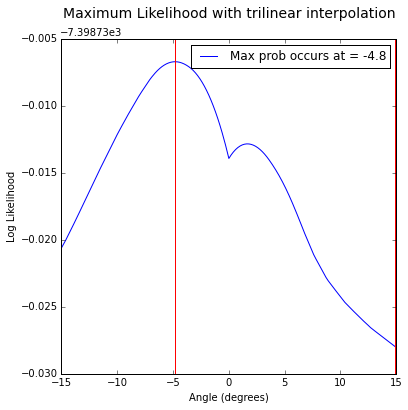

In [92]:
# Discrete Sum Cost Function with rotation matrix
thetas=np.arange(-15,15,0.1)
t = np.zeros([3,])
# without circular mask
fig, ax = plt.subplots(1,1)
fig.set_figwidth(6)
fig.set_figheight(6)
CI = Maximum_Likelihood(vol1, vol2, thetas, t, ax, rotate='q')
print CI
plt.show()
plt.close(fig)

In [75]:
from scipy.stats import norm
thetas=np.arange(-6,-4,0.5)
t = np.zeros([3,])
sig = 0.25
x = np.linspace(norm.ppf(0.01, 0, sig), norm.ppf(0.99, 0, sig), 100)
y = norm.pdf(x, 0, sig)
for th in thetas:
    new_vol2 = bessel_rotate_3d(vol2, 0, th, 0)
    data = (new_vol2-vol1).ravel()
    plt.hist(2*data/((new_vol2+vol1).ravel()), bins=100, normed=True)
    plt.plot(x, y,'r-', lw=5, alpha=0.6, label = 'pdf of $N(0,0.5^2)$')
    plt.title('im2 rotated %s degrees' % -th)
    plt.legend()
    plt.show()

KeyboardInterrupt: 

In [ ]:
from 